In [1]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.constants as con
import astropy.units as u
import scipy
from scipy.signal import argrelmin
import ugradio

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

No module named 'rtlsdr'


In [2]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))

## Sun 6hr

In [3]:
sun_data, sun_times = np.load('sun_6hr.npy')

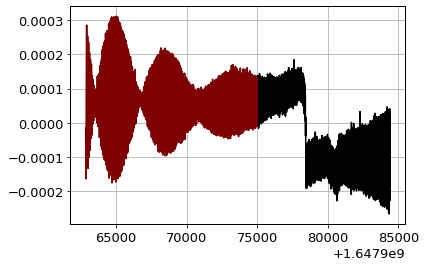

In [4]:
plt.plot(sun_times, sun_data, c='k')

# making a cut in the data because after a certain point it looks bad
index = 13500
sun_times_cut, sun_data_cut = sun_times[:index], sun_data[:index]
plt.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='r')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


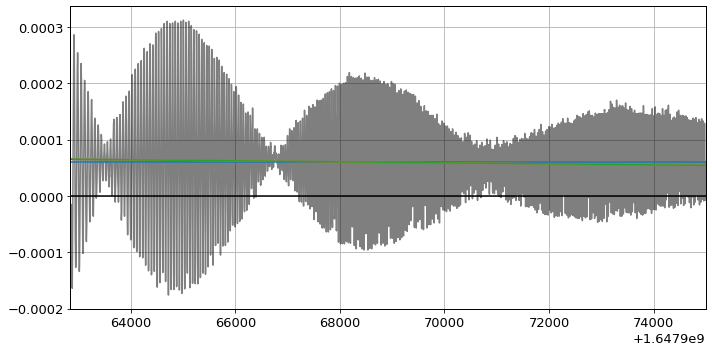

In [5]:
# trying to get it to lie at zero

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axhline(0, c='k')
ax.set_xlim(min(sun_times_cut), max(sun_times_cut))
ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')

# # subtract off median
# median = np.median(sun_times_cut)
# plt.plot(sun_times_cut-median, sun_data_cut, alpha=0.5)

# subtract off mean
mean = np.mean(sun_data_cut)
ax.axhline(mean)

# poly fit, for every chunk calc mean and fit to that
p1 = np.polyfit(sun_times_cut, sun_data_cut, deg=1)
p2 = np.polyfit(sun_times_cut, sun_data_cut, deg=2)
p3 = np.polyfit(sun_times_cut, sun_data_cut, deg=3)


def use_polyfit(x, *p):
    coeff_num = len(p[0])
    p = p[0]
    if coeff_num == 2: # deg 1
        return p[0]*x + p[1]
    elif coeff_num == 3: # deg 2
        return p[0]*x**2 + p[1]*x + p[2]
    elif coeff_num == 4: # deg 3
        return p[0]*x**3 + p[1]*x**2 + p[2]*x + p[3]
    elif coeff_num == 5: # deg 3
        return p[0]*x**4 + p[1]*x**3 + p[2]*x**2 + p[3]*x + p[4]

y1 = use_polyfit(sun_times_cut, p1)
ax.plot(sun_times_cut, y1)

y2 = use_polyfit(sun_times_cut, p2)
ax.plot(sun_times_cut, y2)

y3 = use_polyfit(sun_times_cut, p3)
ax.plot(sun_times_cut, y3)

# RESIDUAL PLOT
# ax[1].set_xlim(min(sun_times_cut), max(sun_times_cut))
# ax[1].plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')
# ax[1].plot(sun_times_cut, sun_data_cut - mean)
# ax[1].plot(sun_times_cut, sun_data_cut - y1)
# ax[1].plot(sun_times_cut, sun_data_cut - y2)
# ax[1].plot(sun_times_cut, sun_data_cut - y3)

plt.tight_layout()

In [6]:
len(sun_times_cut)

13500

45


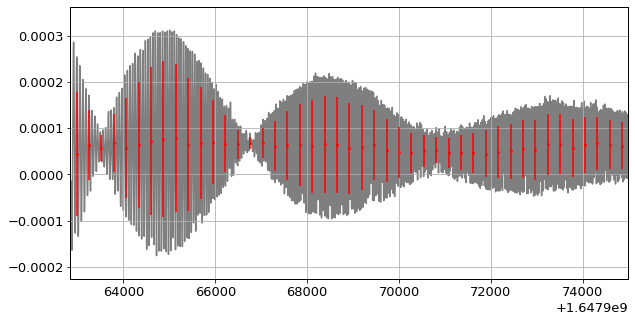

In [7]:
# SEPERATE DATA INTO SMALL CHUNKS AND CALCULATE MEAN OVER EACH CHUNK
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
num_data_in_chunk = 300

chunks = len(sun_times_cut)/num_data_in_chunk

split_data = np.split(sun_data_cut, chunks)
split_data_mean = np.mean(split_data, axis=1) # mean for each data chunk
split_data_std = np.std(split_data, axis=1)

print(len(split_data_mean))

split_times = np.split(sun_times_cut, chunks)
split_times_middle = np.mean(split_times, axis=1) # get center of each chunk?

ax.scatter(split_times_middle, split_data_mean, zorder=1, c='r', s=3)
ax.errorbar(split_times_middle, split_data_mean, split_data_std, linestyle='none', c='r')

ax.set_xlim(min(sun_times_cut), max(sun_times_cut))
ax.set_ylim(min(sun_data_cut)-0.00005, max(sun_data_cut)+0.00005)
ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k', zorder=0)

determined that spliting our data into 300 chunks was the best. Wanted as mancy chunks as possible without
there being enough data points for the chunk to accurately capture to behavior of that time. With more chunks
than 300, we considered too few points and our means oscillated wildly. With fewer chunks than 300, we risk
averaging over too many points which would defeat the purpose of calculating the mean in separate chunks. We
experimented with values from 10 to 1000.

In [8]:
sub_split_data = []
for i in range(len(split_data)):
    val = split_data[i] - split_data_mean[i]
    sub_split_data.append(val)
sub_split_data = np.array(sub_split_data)

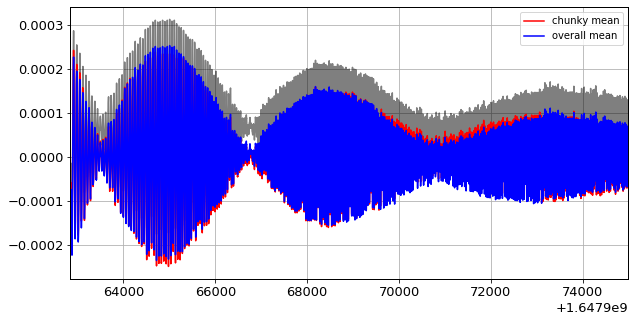

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')
ax.plot(sun_times_cut, sub_split_data.reshape(13500, -1), c='r', label='chunky mean')
ax.plot(sun_times_cut, sun_data_cut - mean, c='b', label='overall mean')

ax.legend()

In [10]:
# compare means, which closest to zero?
print('Subtracting off chunky mean gives mean of {:.3}'.format(np.mean(sub_split_data.reshape(13500, -1))))
print('Subtracting off overall mean gives mean of {:.3}'.format(np.mean(sun_data_cut - mean)))

Subtracting off chunky mean gives mean of -6.02e-22
Subtracting off overall mean gives mean of 4.37e-21


we will use the "chunky mean" method because it better centers our data about zero although it is only slightly
better than just subtracting off the overall mean.

## bessel function

In [11]:
# first we have to fft to get rid of low frequencyies (oscillations within the envelope)

In [12]:
x = np.linspace(0.01,15,10000)
j1 = scipy.special.j1(x)

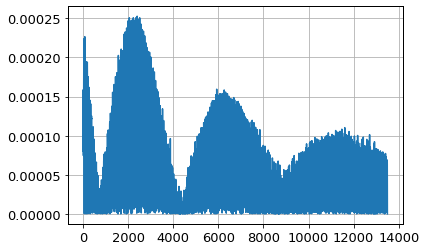

In [13]:
abs_data = np.abs(sun_data_cut - mean)
plt.plot(abs_data)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


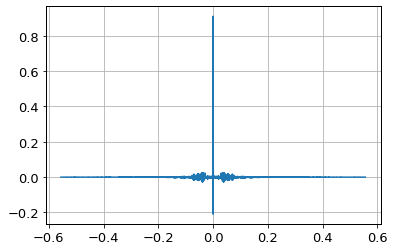

In [14]:
fft = np.fft.fftshift(np.fft.fft(abs_data))
freqs = freq(sun_times_cut, np.mean(np.diff(sun_times_cut)))
plt.plot(freqs, fft)
# plt.ylim(0,.2)
# plt.xlim(-0.1, 0.1)

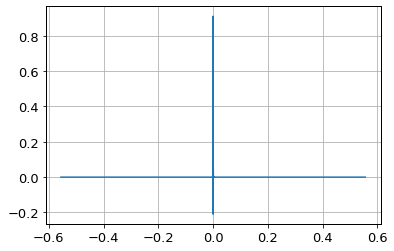

In [15]:
fft[np.where(freqs > 0.002)] = 0
fft[np.where(freqs < -0.002)] = 0
plt.plot(freqs, fft)

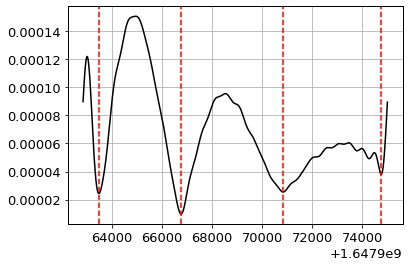

In [16]:
filtered_sun_data = np.fft.ifft(fft)
centered_abs_filtered = np.abs(filtered_sun_data - np.mean(filtered_sun_data))
plt.plot(sun_times_cut, centered_abs_filtered, c='k')

index = scipy.signal.argrelmin(centered_abs_filtered, order=2000)

minima = sun_times_cut[index]

for i in minima:
    plt.axvline(i, c='r', linestyle='--')

In [17]:
minima_data

NameError: name 'minima_data' is not defined

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


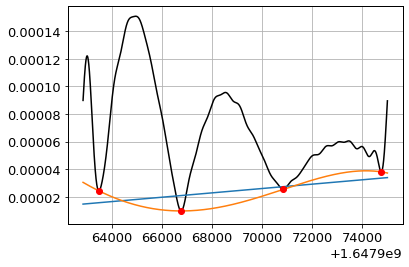

In [18]:
minima = sun_times_cut[index] - sun_times_cut[0]
minima_data = centered_abs_filtered[index]

plt.plot(sun_times_cut, centered_abs_filtered, c='k')
plt.scatter(minima + sun_times_cut[0], minima_data, c='r', zorder=5)

p1 = np.polyfit(minima, minima_data, deg=1)
y1 = np.polyval(p1, sun_times_cut - sun_times_cut[0])
plt.plot(sun_times_cut, y1)

p2 = np.polyfit(minima, minima_data, deg=4)
y2 = np.polyval(p2, sun_times_cut - sun_times_cut[0])
plt.plot(sun_times_cut, y2)

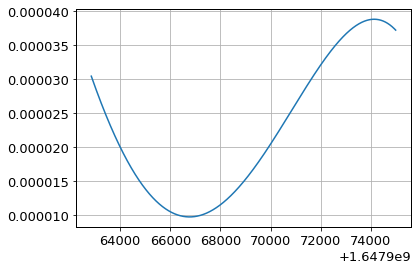

In [19]:
plt.plot(sun_times_cut, y2)

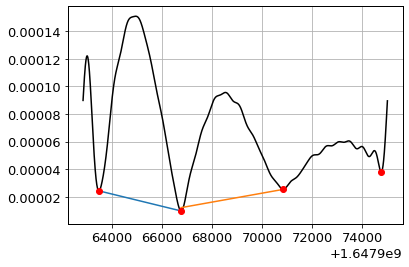

In [20]:
minima = sun_times_cut[index]
minima_data = centered_abs_filtered[index]

plt.plot(sun_times_cut, centered_abs_filtered, c='k')
plt.scatter(minima, minima_data, c='r', zorder=5)

p_1 = np.polyfit(minima[:2], minima_data[:2], deg=1)
y_1 = use_polyfit(sun_times_cut[(index[0][0]):(index[0][1])], p_1)
plt.plot(sun_times_cut[(index[0][0]):(index[0][1])], y_1)

p_2 = np.polyfit(minima[2:4], minima_data[2:4], deg=1)
y_2 = use_polyfit(sun_times_cut[(index[0][1]):(index[0][2])], p_2)
plt.plot(sun_times_cut[(index[0][1]):(index[0][2])], y_2)

# p_2 = np.polyfit(minima[4:5], minima_data[4:5], deg=1)
# y_2 = use_polyfit(sun_times_cut[(index[0][2]):(index[0][3])], p_2)
# plt.plot(sun_times_cut[(index[0][2]):(index[0][3])], y_2)

# p2 = np.polyfit(minima, minima_data, deg=2)
# y2 = use_polyfit(sun_times_cut, p2)
# plt.plot(sun_times_cut, y2)

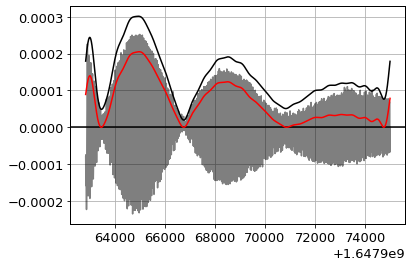

In [21]:
centered_abs_filtered[np.where((sun_times < minima[1]) & (sun_times > minima[2]))] *= -1
# centered_abs_filtered[np.where( (sun_times > minima[2]) & (sun_times < minima[3]) )] *= -1

# unabs_envelope = -centered_abs_filtered[np.where((sun_times > minima[0]))]
# unabs_envelope = -unabs_envelope[np.where((sun_times < minima[1]))]

plt.plot(sun_times_cut, 2*centered_abs_filtered, c='k', zorder=5) # envelope
# plt.plot(sun_times_cut, 2*centered_abs_filtered-y1, c='r', zorder=5) # fitted 1st and subtracted envelope
# plt.plot(sun_times_cut, 2*centered_abs_filtered-y2, c='orange', zorder=5) # fitted 2nd and subtracted envelope
plt.plot(sun_times_cut, 1.5*(centered_abs_filtered - y2), c='r', zorder=6)
plt.plot(sun_times_cut, sun_data_cut-mean, alpha=0.5, c='k', zorder=5) # data

plt.axhline(0, c='k')

In [24]:
def bessel(ha, thetaR, A):
    delta = 0
    d = 14.7106 #m
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * thetaR * u
#     print("x", x[1])
    return A * scipy.special.j1(x) / x

In [47]:
# p0 = [0.0046, 0.5]
p0 = [0.04, 0.00001]
pars, cov = scipy.optimize.curve_fit(bessel, sun_times_cut, centered_abs_filtered - y2, p0)

In [48]:
# val = con.c / (10.5e9 * u.Hz)
# λ = val.to(u.m).value
# # print("lambda", λ)

# L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 

# jds=ugradio.timing.julian_date(sun_times_cut)
# alpha,delta =ugradio.coord.sunpos(jds[0])
# delta=(np.pi/180)*delta
# LSTs = ugradio.timing.lst(jds,lon=long)
# hs = LSTs - alpha*(np.pi/180)
# # print(len(hs))
# ha = np.linspace(hs[0],(hs[0]+(15*6*0.4682857619762978)*(np.pi/180)),len(jds))
# print(ha[1])

# p0 = [0.0046, 0.5]
# pars, cov = scipy.optimize.curve_fit(bessel, ha, centered_abs_filtered - y2, p0)

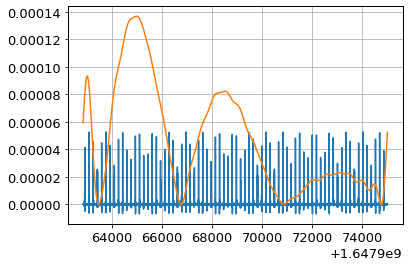

In [49]:
plt.plot(sun_times_cut, bessel(sun_times_cut, pars[0], pars[1]))
plt.plot(sun_times_cut, centered_abs_filtered- y2)